<h1>Паращина Арина, БПАДИ242С </h1>


# Задание

Конахан и соавторы определили среднее артериальное давление и общее периферическое сосудистое сопротивление при операциях на открытом сердце с галотановой и морфиновой анестезией. Можно ли утверждать, что в группах галотановой и морфиновой анестезии эти гемодинамические показатели различаются статистически значимо? Провести описательный анализ данных (среднее, стандартное отклонение, дисперсия, медиана, мода, квартили). Проверить гипотезу при уровне значимости 0,05. Проверить при уровне значимости 0,05 гипотезу о нормальном законе распределения соответствующего признака с помощью критериев согласия. Сформулировать и аргументировать используемые статистические критерии.


## Изучение данных из файла


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from scipy import stats
from scipy.stats import kstest, norm, ttest_ind, mannwhitneyu

In [14]:
data = pd.read_csv('HW1.csv')

data = data.rename(columns={
    'Среднее артериальное давление': 'САД',
    'Общее периферическое сосудистое сопротивление': 'ОПСС',
})

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Пациент   240 non-null    int64 
 1   САД       240 non-null    int64 
 2   ОПСС      240 non-null    int64 
 3   Препарат  240 non-null    object
dtypes: int64(3), object(1)
memory usage: 7.6+ KB


,Пациент,САД,ОПСС,Препарат
0,1,83,1600,Галотан
1,2,76,2000,Галотан
2,3,75,2200,Галотан
3,4,86,2200,Галотан
4,5,75,2300,Галотан


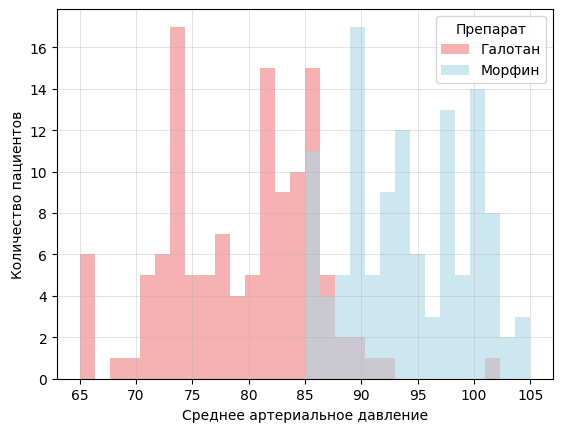

In [15]:
data.pivot(columns='Препарат')['САД'].plot.hist(bins=30, alpha=0.6, color=['lightcoral', 'lightblue'])
plt.xlabel('Среднее артериальное давление')
plt.ylabel('Количество пациентов')
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()

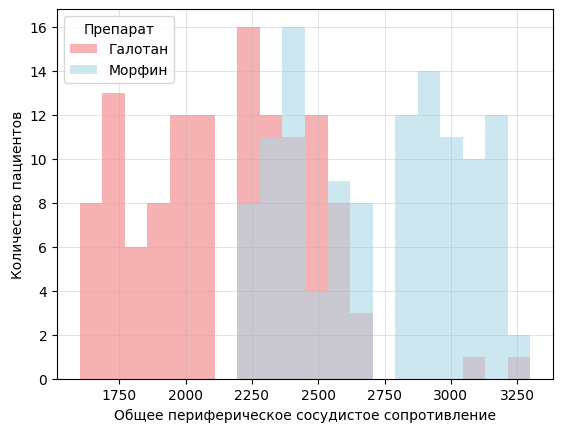

In [16]:
data.pivot(columns='Препарат')['ОПСС'].plot.hist(bins=20, alpha=0.6, color=['lightcoral', 'lightblue'])

plt.xlabel('Общее периферическое сосудистое сопротивление')
plt.ylabel('Количество пациентов')
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()


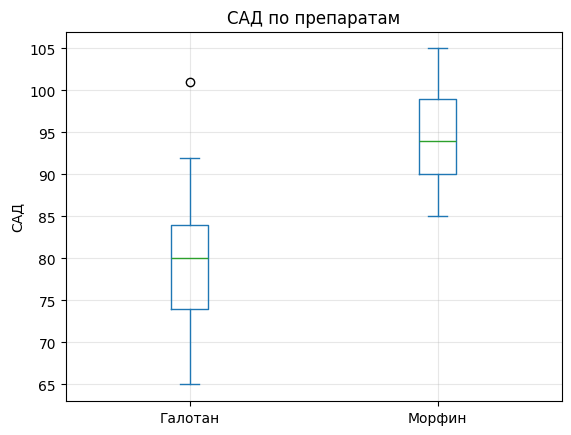

In [17]:
data.pivot(columns='Препарат')['САД'].plot.box()
plt.title('САД по препаратам')
plt.ylabel('САД')
plt.grid(True, alpha=0.3)
plt.show()

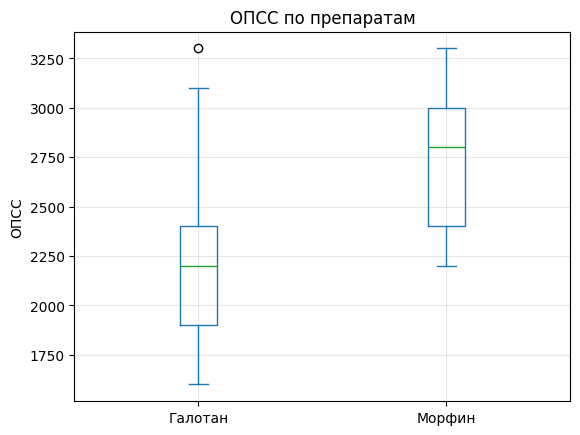

In [18]:
data.pivot(columns='Препарат')['ОПСС'].plot.box()
plt.title('ОПСС по препаратам')
plt.ylabel('ОПСС')
plt.grid(True, alpha=0.3)
plt.show()

Из гистограмм и ящиков с усами видно, что между двумя группами есть визуальная разница: при проведении операций с морфиновой анестезией артериальное давление и общее периферическое сосудистое сопротивление в среднем выше, чем при использовании галотановой анестезии.

Однако, основываясь только на графиках, утверждать, что показатели различаются статистически значимо, нельзя. Для такого утверждения проведем статистические тесты и анализ p-value.

## Описательный анализ

In [19]:
print("СТАТИСТИКИ".center(100))


all_stats = []
variables = ['САД', 'ОПСС']
groups = sorted(data['Препарат'].unique())
for variable in variables:
  for group in groups:

        group_data = data[data['Препарат'] == group][variable].dropna()
        all_stats.append([
            f'Препарат {group}',
            variable,
            f"{group_data.mean():.1f}",
            f"{group_data.std(ddof=1):.1f}",
            f"{group_data.var():.1f}",
            f"{group_data.median():.1f}",
            f"{group_data.mode().iloc[0]:.1f}",
            f"{group_data.quantile(0.25):1f}",
            f"{group_data.quantile(0.75):.1f}"
        ])

headers = ['Препарат', 'Показатель', 'Среднее', 'Стд.откл.', 'Дисперсия', 'Медиана', 'Мода', 'Q1', 'Q3']
print(tabulate(all_stats, headers=headers, tablefmt='grid', stralign='center', numalign='center'))

                                             СТАТИСТИКИ                                             
+------------------+--------------+-----------+-------------+-------------+-----------+--------+------+------+
|     Препарат     |  Показатель  |  Среднее  |  Стд.откл.  |  Дисперсия  |  Медиана  |  Мода  |  Q1  |  Q3  |
+==================+==============+===========+=============+=============+===========+========+======+======+
| Препарат Галотан |     САД      |   79.2    |     6.5     |    42.3     |    80     |   73   |  74  |  84  |
+------------------+--------------+-----------+-------------+-------------+-----------+--------+------+------+
| Препарат Морфин  |     САД      |   94.1    |     5.4     |    29.1     |    94     |  100   |  90  |  99  |
+------------------+--------------+-----------+-------------+-------------+-----------+--------+------+------+
| Препарат Галотан |     ОПСС     |  2151.2   |    336.4    |   113175    |   2200    |  2200  | 1900 | 2400 |
+----------

По данным характеристикам также можем наблюдать, что  при проведении операций с морфиновой анестезией артериальное давление и общее периферическое сосудистое сопротивление выше, чем при использовании галотановой анестезии.

# Проверка гипотез


H₀: Выборка данных соответствует закону нормального распределения

H₁ : Выборка данных не соответствует закону нормального распределения

Проверим нормальность распределения в каждой группе с помощью критерия Колмогорова-Смирнова

In [26]:
for drug in data['Препарат'].unique():

    drug_data = data[data['Препарат'] == drug]


    n = len(drug_data)

    mean_sad = np.mean(drug_data['САД'])
    std_sad = np.std(drug_data['САД'])
    ks_sad, p_sad = kstest(drug_data['САД'], 'norm', args=(mean_sad, std_sad))

    mean_opss = np.mean(drug_data['ОПСС'])
    std_opss = np.std(drug_data['ОПСС'])
    ks_opss, p_opss = kstest(drug_data['ОПСС'], 'norm', args=(mean_opss, std_opss))

    print(f"{drug} (n={n}):")
    print(f"  САД: p-value = {p_sad:.4f} -> {'нормальное' if p_sad > 0.05 else 'не нормальное'}")
    print(f"  ОПСС: p-value = {p_opss:.4f} -> {'нормальное' if p_opss > 0.05 else 'не нормальное'}")
    print()

Галотан (n=123):
  САД: p-value = 0.1353 -> нормальное
  ОПСС: p-value = 0.3646 -> нормальное

Морфин (n=117):
  САД: p-value = 0.1904 -> нормальное
  ОПСС: p-value = 0.0130 -> не нормальное



Для САД: распределение в обеих группах соответствует нормальному
(p > 0,05). При выполнении условия нормальности и достаточного
объема выборок для сравнения групп был выбран
t-критерий Стьюдента для независимых выборок.  
H₀: Средние значения САД в двух группах равны

H₁ : Средние значения САД в двух группах не равны

In [37]:

group1_sad = data[data['Препарат'] == 'Галотан']['САД']
group2_sad = data[data['Препарат'] == 'Морфин']['САД']



t_stat, p_value = ttest_ind(group1_sad, group2_sad)

print(f"\nРезультаты t-теста для САД:")
print(f"t-статистика = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: p-value ({p_value:.4f}) < α ({alpha})")
    print("Различие между группами статистически значимо")
else:
    print(f"\nВывод: p-value ({p_value:.4f}) > α ({alpha})")
    print("Различие между группами не статистически значимо")


Результаты t-теста для САД:
t-статистика = -19.2320
p-value = 0.0000

Вывод: p-value (0.0000) < α (0.05)
Различие между группами статистически значимо


Для ОПСС: распределение во второй группе не соответствует нормальному, поэтому будем использовать U-тест Манна-Уитни.  
H₀: Средние значения ОПСС в двух группах равны

H₁ : Средние значения ОПСС в двух группах не равны

In [34]:


group1_opss = data[data['Препарат'] == 'Галотан']['ОПСС']
group2_opss = data[data['Препарат'] == 'Морфин']['ОПСС']



u_stat, p_value = mannwhitneyu(group1_opss, group2_opss, alternative='two-sided')

print(f"\nРезультаты U-теста Манна-Уитни для ОПСС:")
print(f"U-статистика = {u_stat:.4f}")
print(f"p-value = {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nВывод: p-value ({p_value:.4f}) < α ({alpha})")
    print(" Различие между группами статистически значимо")
else:
    print(f"\nВывод: p-value ({p_value:.4f}) > α ({alpha})")
    print(" Различие между группами не статистически значимо")


Результаты U-теста Манна-Уитни для ОПСС:
U-статистика = 1685.0000
p-value = 0.0000

Вывод: p-value (0.0000) < α (0.05)
 Различие между группами статистически значимо


# Вывод

На основании проведенного статистического анализа данных исследования Конахана и соавторов были получены следующие результаты:

Для среднего артериального давления (САД):

1) Распределение значений в обеих группах соответствует нормальному закону

2) Применен t-критерий Стьюдента

3) Различие между группами статистически значимо

Для общего периферического сосудистого сопротивления (ОПСС):

1) Распределение в группе с препаратом 'Морфин' не соответствует нормальному (p < 0,05)

2) Применен непараметрический U-критерий Манна-Уитни

3) Различие между группами статистически значимо

На основании статистического анализа установлено, что различия в обоих показателях между группами галотановой и морфиновой анестезии являются статистически значимыми.